# <center>Network Science</center>

## <center>Home Assignment #1: Power law</center>

### <center>Student: *Dmitriy Meynster*</center>

#### <hr /> General Information

**Due Date:** 15.02.2016 23:59 <br \>
**Late submission policy:** -2 points per day <br \>


Please send your reports to <network.hse.2016@gmail.com> with message subject of the following structure:<br \> **[HSE Networks 2017] *{LastName}* *{First Name}* HA*{Number}***

Support your computations with figures and comments. <br \>
If you are using IPython Notebook you may use this file as a starting point of your report.<br \>
<br \>
<hr \>

In [54]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from math import *
plt.xkcd()
import numpy.random as rnd
%matplotlib inline

## Problems

### Task 1.

Load [wordcounts](http://www.leonidzhukov.net/hse/2015/networks/data/wordcounts.txt) dataset. 
1. Check that Zipf's Law holds
2. Assuming that the data is distributed according to the Power Law, find
 * $\alpha$ of the distribution
 * mean sample variance $\sigma^2$
3. Produce summary of the frequencies: min, max, mean, median

Reading from file and calculating frequencies:

In [21]:
data_lines = open('wordcounts.txt').readlines()
data = {}
for line in data_lines:
    count, word = line.split()
    data[word] = int(count)
    
counts = sorted(data.values(), reverse=True)
counts_total = sum(counts)
frequencies = np.array([1.0 * count / counts_total for count in counts])

To check if Zipf's law holds, we may check whether sum of squared redisuals (comparing empirical results with theoretical behaviour) is small enough:

In [30]:
sum_sq = np.var(frequencies - [frequencies[0] / (i + 1) for i in xrange(len(frequencies))])
print("sum of squared residuals: %.2e" % sum_sq)

sum of squared residuals: 2.27e-07


As we can see, it is pretty low, so we can say that Zipf's law holds.

We find $\alpha$ and $\sigma^2$ of the distribution via maximum likelyhood (here n is length of dataset, $x_i$ is i'th word count):

$\alpha = 1 + n \left[ \sum\limits_{i=1}^{n} \ln \frac{x_i}{x_{min}} \right]^{-1}, \quad \sigma = \frac{\alpha - 1} {\sqrt{n}}$ 

In [52]:
x_min = min(counts)
n = len(counts)
alpha = 1 + n / sum([log(1.0 * xi / x_min) for xi in counts])

sigma = (alpha - 1) / sqrt(n)
print("alpha: %f, sigma^2: %f" % (alpha, sigma ** 2))

alpha: 1.801639, sigma^2: 0.000118


Summary of the frequencies:

In [19]:
print("Min frequency: %f, max frequency: %f, mean: %f, median: %f" %(min(frequencies), max(frequencies), np.mean(frequencies), np.median(frequencies)))

Min frequency: 0.000013, max frequency: 0.099371, mean: 0.000183, median: 0.000032


### <hr /> Task 2.

Find and plot PDF and CDF for the following networks:
* [Routing network](http://www.leonidzhukov.net/hse/2015/networks/data/network.txt)
* [Web graph](http://www.leonidzhukov.net/hse/2015/networks/data/web_Stanford.txt)

1. Are they correspondent to power law?
2. Find max and mean values of incoming and outcoming node degrees
3. Find $\alpha$ via Maximum Likelihood and calculate $\sigma^2$
4. Determine $x_{min}$ via Kolmogorov-Smirnov test
5. Try to fit Erdos model for the Web Graph and describe common and different points in their descriptive statistics

#### Routing network

Note that the graph is undirected.

In [55]:
G = nx.read_edgelist(path="network.txt")

Some helper functions:

In [165]:
def get_freqs(degrees):
    freqs = {}
    
    for degree in degrees:
        freqs.setdefault(degree, 0)
        freqs[degree] += 1.0 / len(degrees)
        
    return freqs

def get_freqs_cumulative(degrees):
    freqs = get_freqs(degrees)
    freqs_cumulative = {}
    acc = 0
    
    for degree in sorted(freqs.keys()):
        acc += freqs[degree]
        freqs_cumulative[degree] = acc
        
    return freqs_cumulative

def get_binned_freqs(degrees, base=2):
    freqs = get_freqs(degrees)
    freqs_binned = {}
    
    for degree in freqs.keys():
        f_bin_upper = exp(ceil(log(degree, base))) 
        f_bin = (0.5 * f_bin_upper) if (f_bin_upper == 1) else ((1 + base) * f_bin_upper)
        freqs_binned.setdefault(f_bin, 0)
        freqs_binned[f_bin] += freqs[degree]
        
    return freqs_binned


PDF (with log binning):

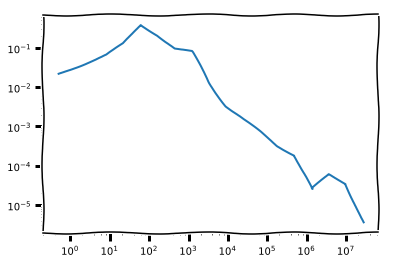

In [155]:
degrees = sorted(list(nx.degree(G).values()))
freqs_binned = get_binned_freqs(degrees)
plt.loglog(sorted(freqs_binned.keys()), [freqs_binned[key] for key in sorted(freqs_binned.keys())])

CDF:

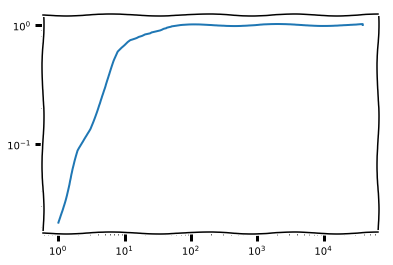

In [154]:
freqs_cumulative = get_freqs_cumulative(degrees)
plt.loglog(sorted(freqs_cumulative.keys()), [freqs_cumulative[key] for key in sorted(freqs_cumulative.keys())])

We use linear regression to check whether this graph satisfies power law:

determinancy coefficient: 0.708105


<module 'matplotlib.pyplot' from '/home/mdldml/.local/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

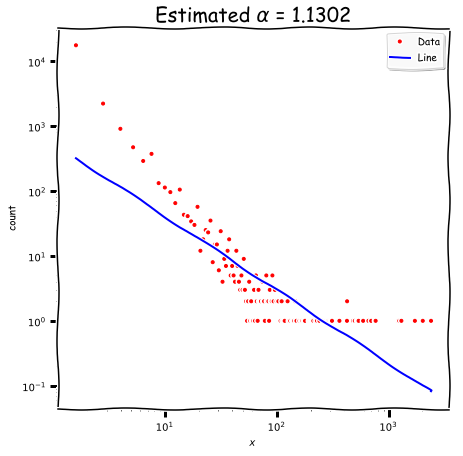

In [63]:
def check_power_law(degrees):
    n = len(degrees)
    yh, binEdges = np.histogram(list(degrees), bins=2000)#, range=r)
    bincenters = 0.5 * (binEdges[1:] + binEdges[:-1])

    x_est = np.freqlog(bincenters[np.ix_(yh != 0)])
    y_est = np.log(yh[np.ix_(yh != 0)])

    X = np.vstack([np.ones(len(x_est)), x_est]).T
    Beta = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), y_est)

    # idx = np.argsort(x_est)
    yt = np.exp(X[:,:].dot(Beta))
    xt = np.exp(X[:, 1])

    fig, ax = plt.subplots()
    fig.set_size_inches(7, 7)
    ax.loglog(bincenters, yh, '.r', label='Data') 
    ax.loglog(xt, yt, 'b', label='Line')
    plt.ylabel('count')
    plt.xlabel('$x$')
    ax.legend(loc='upper right', shadow=True)
    plt.title('Estimated $\\alpha$ = {0:1.4f}'.format(-Beta[1]), fontsize=20)

    det_coeff = 1 - np.sum(np.square(X.dot(Beta) - y_est)) / np.sum(np.square(np.mean(y_est) - y_est))
    print("determinancy coefficient: %f" % det_coeff)
    
    return plt

check_power_law(degrees)

As we can see, determinancy coefficient is large enough, so probably this graph satisfies power law. 

Max and mean values of node degrees:

In [80]:
degrees = sorted(list(nx.degree(G).values()))
print("max value: %d, mean value: %f" % (max(degrees), np.mean(degrees)))

max value: 38626, mean value: 16.406331


Estimation of $\alpha$ and $\sigma^2$ via power law (see formulae above, in the first task):

In [59]:
x_min = min(degrees)
n = len(degrees)
alpha = 1 + n / sum([log(1.0 * xi / x_min) for xi in degrees])

sigma = (alpha - 1) / sqrt(n)
print("alpha: %f, sigma^2: %f" % (alpha, sigma ** 2))

alpha: 2.435172, sigma^2: 0.000090


Now let's find $x_{min}$ via Kolmogorov-Smirnov test:

In [157]:
def find_xmin(alpha, degrees):
    
    cache = get_freqs_cumulative(degrees)
        
    def diff(xmin):
        
        def Fth(x):
            C = (alpha - 1) * (xmin ** (alpha - 1))
            return 1 - C / (alpha - 1) * (x ** (-(alpha - 1)))
        
        def Femp(x):
            return cache[x]
        
        result = 0.0
        
        for x in sorted(cache.keys()):
            result = max(result, abs(Fth(x) - Femp(x)))
        
        return result
    
    min_diff = 1e+100
    xmin = 0
    
    for deg in sorted(cache.keys()):
        curr_diff = diff(deg)
        if min_diff > curr_diff:
            min_diff = curr_diff
            xmin = deg
    
    return xmin

In [158]:
find_xmin(alpha, degrees)

1

#### Web graph

In [87]:
G = nx.read_edgelist(path="web_Stanford.txt", create_using=nx.DiGraph())

This graph is directed, so we investigate both incoming and outgoing degrees:

In [104]:
in_degrees = np.array(sorted(list(G.in_degree(G.nodes()).values())))
out_degrees = np.array(sorted(list(G.out_degree(G.nodes()).values())))

PDFs (with log binning):

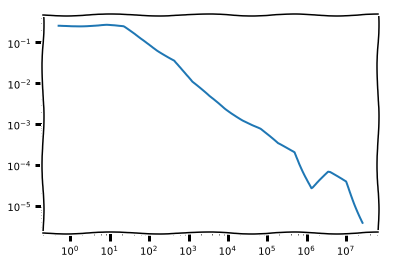

In [161]:
in_freqs_binned = get_binned_freqs(in_degrees[in_degrees != 0])
plt.loglog(sorted(in_freqs_binned.keys()), [in_freqs_binned[key] for key in sorted(in_freqs_binned.keys())])

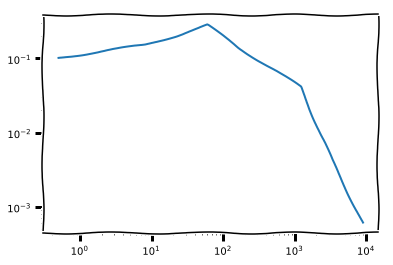

In [166]:
out_freqs_binned = get_binned_freqs(out_degrees[out_degrees != 0])
plt.loglog(sorted(out_freqs_binned.keys()), [out_freqs_binned[key] for key in sorted(out_freqs_binned.keys())])

CDFs:

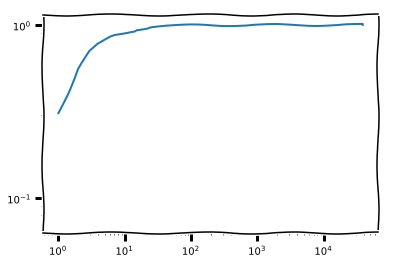

In [167]:
in_freqs_cumulative = get_freqs_cumulative(in_degrees)
plt.loglog(sorted(in_freqs_cumulative.keys()), [in_freqs_cumulative[key] for key in sorted(in_freqs_cumulative.keys())])

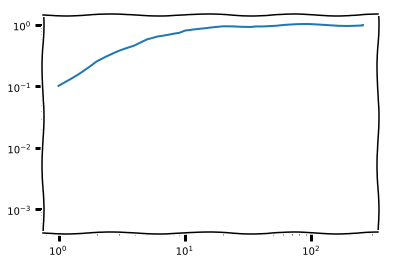

In [168]:
out_freqs_cumulative = get_freqs_cumulative(out_degrees)
plt.loglog(sorted(out_freqs_cumulative.keys()), [out_freqs_cumulative[key] for key in sorted(out_freqs_cumulative.keys())])

determinancy coefficient: 0.671924


<module 'matplotlib.pyplot' from '/home/mdldml/.local/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

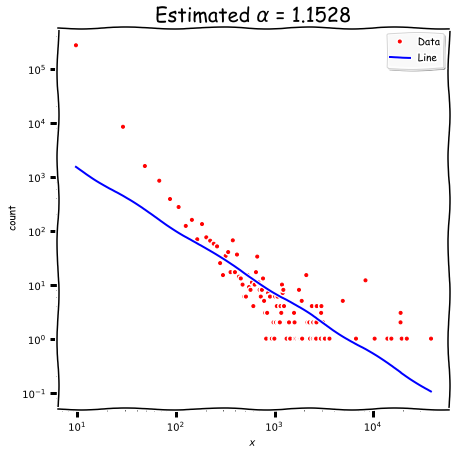

In [105]:
check_power_law(in_degrees)

determinancy coefficient: 0.744528


<module 'matplotlib.pyplot' from '/home/mdldml/.local/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

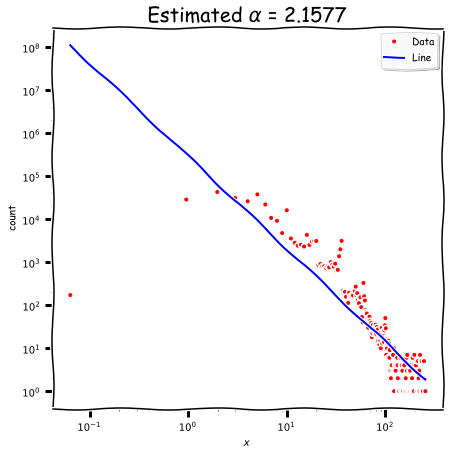

In [106]:
check_power_law(out_degrees)

As we can see, both determinancy coefficients are large enough, so probably this graph satisfies power law. 

Max and mean values of incoming and outcoming node degrees:

In [107]:
print("Incoming node degrees, max value: %d, mean value: %f" % (max(in_degrees), np.mean(in_degrees)))

Incoming node degrees, max value: 38606, mean value: 8.203166


In [108]:
print("Outgoing node degrees, max value: %d, mean value: %f" % (max(out_degrees), np.mean(out_degrees)))

Outgoing node degrees, max value: 255, mean value: 8.203166


Estimation of $\alpha$ and $\sigma^2$ via power law (see formulae above, in the first task):

In [122]:
in_degrees_nonzero = in_degrees[in_degrees != 0]
x_min = min(in_degrees_nonzero)
n = len(in_degrees_nonzero)
in_alpha = 1 + n / sum([log(1.0 * xi / x_min) for xi in in_degrees_nonzero])

in_sigma = (in_alpha - 1) / sqrt(n)
print("incoming degrees, alpha: %f, sigma^2: %f" % (in_alpha, in_sigma ** 2))

incoming degrees, alpha: 1.954128, sigma^2: 0.000003


In [128]:
out_degrees_nonzero = out_degrees[out_degrees != 0]
x_min = min(out_degrees_nonzero)
n = len(out_degrees_nonzero)
out_alpha = 1 + n / sum([log(1.0 * xi / x_min) for xi in out_degrees_nonzero])

out_sigma = (out_alpha - 1) / sqrt(n)
print("outgoing degrees, alpha: %f, sigma^2: %f" % (out_alpha, out_sigma ** 2))

outgoing degrees, alpha: 1.626180, sigma^2: 0.000001


Now let's find $x_{min}$ via Kolmogorov-Smirnov test, for incoming and outgoing edges, respectively:

In [133]:
find_xmin(in_alpha, in_degrees_nonzero)

1

In [134]:
find_xmin(out_alpha, out_degrees_nonzero)

1